In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import r2_score,mean_absolute_percentage_error

In [3]:
df0=pd.read_csv("TSLA.csv",index_col=0,parse_dates=True)

In [4]:
df=df0[['Close']].copy()

In [5]:
df['logclose']=np.log(df['Close'])
df['logdif']=df['logclose'].diff()




In [6]:
n=12
train=df.iloc[:-n]
test=df.iloc[-n:]


In [7]:
series=df['logdif'][1:].values
T=10

X=[]
Y=[]

for t in range(len(series)-T):
  x=series[t:t+T]
  X.append(x)
  y=series[t+T]
  Y.append(y)
X=np.array(X)
y=np.array(Y)

In [8]:
X_train,y_train=X[:-n],Y[:-n]
X_test,y_test=X[-n:],Y[-n:]

In [9]:
train_idx=df.index<=train.index[-1]
test_idx=df.index>train.index[-1]

train_idx[:T+1]=False

In [10]:
last_train=train.iloc[-1]['logclose']
test_logclose=df.iloc[-n:]['logclose']

df['shiflogclose']=df['logclose'].shift(1)
prev=df['shiflogclose']

In [11]:
def one_step_and_multistep_forecast(model,name):
  model.fit(X_train,y_train)
  print("One-step and Multi forecast of",name)

  df.loc[train_idx,f'{name}_one_step_train']=prev[train_idx]+model.predict(X_train)
  df.loc[test_idx,f'{name}_one_step_test']=prev[test_idx]+model.predict(X_test)

  mape=mean_absolute_percentage_error(test_logclose,df.loc[test_idx,f'{name}_one_step_test'])
  print("MAPE-onestep forecast: ",mape)
  multistep_pred=[]

  last_x=X_test[0]

  while len(multistep_pred)<n:
    p=model.predict(last_x.reshape(1,-1))[0]
    multistep_pred.append(p)

    last_x=np.roll(last_x,-1)
    last_x[-1]=p

  df.loc[test_idx,f'{name}_multistep']=last_train+np.cumsum(multistep_pred)

  mape=mean_absolute_percentage_error(test_logclose,df.loc[test_idx,f'{name}_multistep'])
  print("MAPE-Multistep forecast: ",mape)

  cols=['logclose',f'{name}_one_step_train',f'{name}_one_step_test',f'{name}_multistep']

  df.iloc[-100:][cols].plot(figsize=(10,5))

One-step and Multi forecast of LR
MAPE-onestep forecast:  0.0037435401224718413
MAPE-Multistep forecast:  0.0033501312033550803


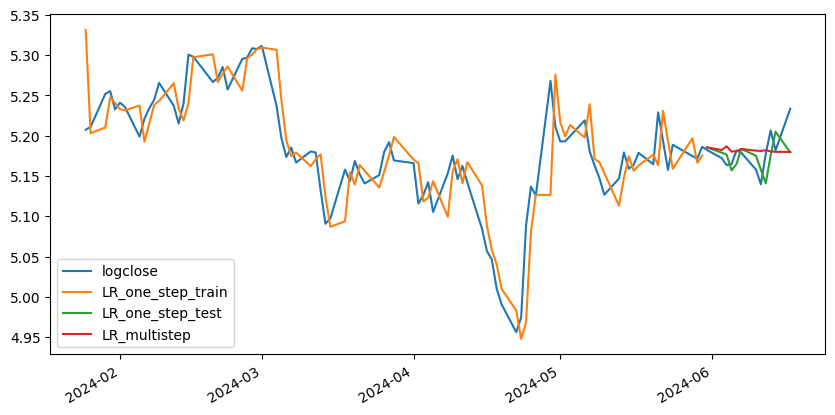

In [12]:
one_step_and_multistep_forecast(LinearRegression(),"LR")

One-step and Multi forecast of SVR
MAPE-onestep forecast:  0.003980935367840198
MAPE-Multistep forecast:  0.009114250115772776


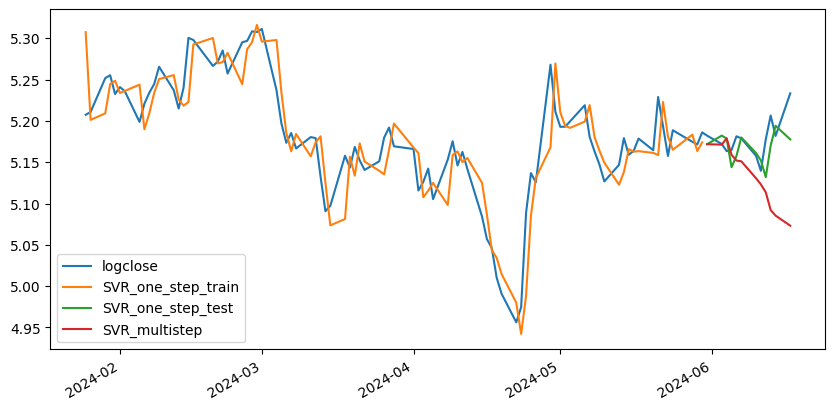

In [13]:
one_step_and_multistep_forecast(SVR(),"SVR")

One-step and Multi forecast of RF
MAPE-onestep forecast:  0.00430021701262636
MAPE-Multistep forecast:  0.008255368932210162


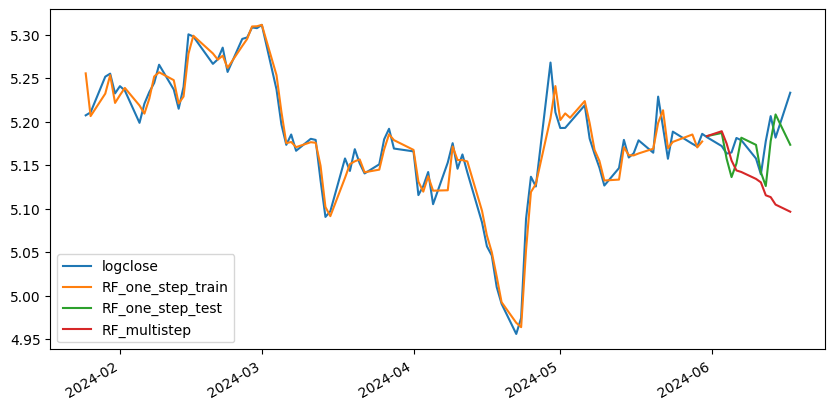

In [14]:
one_step_and_multistep_forecast(RandomForestRegressor(),"RF")

In [15]:
def multi_output_forecast(model,name):

  Tx=T #10
  Ty=n #12

  X=[]
  Y=[]
  for t in range(len(series)-Tx-Ty+1):
    x=series[t:t+Tx]
    X.append(x)
    y=series[t+Tx:t+Tx+Ty]
    Y.append(y)

  X=np.array(X)
  Y=np.array(Y)

  X_train_m,y_train_m=X[:-1],Y[:-1]
  X_test_m,y_test_m=X[-1:],Y[-1:]

  model.fit(X_train_m,y_train_m)

  df.loc[test_idx,f'{name}_multi_out']=last_train+np.cumsum(model.predict(X_test_m).flatten())

  mape=mean_absolute_percentage_error(test_logclose,df.loc[test_idx,f'{name}_multi_out'])

  print("MAPE-multi_output_forecast: ",mape)
  cols=['logclose',f'{name}_one_step_train',f'{name}_one_step_test',f'{name}_multistep',f'{name}_multi_out']

  df.iloc[-100:][cols].plot(figsize=(15,6))


MAPE-multi_output_forecast:  0.004614804922546302


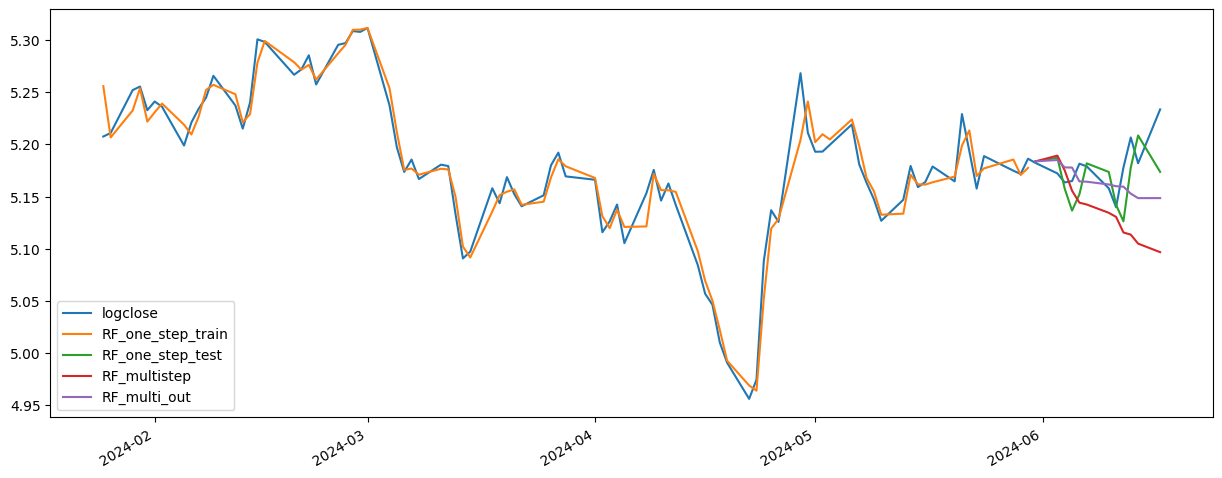

In [16]:
multi_output_forecast(RandomForestRegressor(),"RF")